# Mult-VAE

- [Variational Autoencoders for Collaborative Filtering](https://arxiv.org/pdf/1802.05814.pdf)

# CVAE

- [Collaborative Variational Autoencoder for Recommender Systems
](http://cseweb.ucsd.edu/classes/fa17/cse291-b/reading/p305-li.pdf)

# RecVAE
- [RecVAE: a New Variational Autoencoder for Top-N Recommendations with Implicit Feedback](https://arxiv.org/pdf/1912.11160.pdf)

## Experiment

In [83]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, Input, Reshape, Dense, Dropout, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [84]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''
    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [85]:
ratings = load_data('1m')
ratings.head()

(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [86]:
def preprocessing(df: pd.DataFrame, threshold = 3.5) -> pd.DataFrame:
    df = df[df.rating > threshold]
    more_than_4 = df.groupby('userId')['movieId'].nunique()
    more_than_4 = more_than_4.index[more_than_4 > 4]
    df = df[df.userId.isin(more_than_4)]
    return df.reset_index(drop = True)

In [87]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(f'# of user = {n_user}')

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [88]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [89]:
ratings = preprocessing(ratings)
ratings = Id2idx(ratings)

print(ratings.shape)
ratings.head(5)

(575272, 4)


,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,3,4,978300275
2,0,4,5,978824291
3,0,6,5,978302039
4,0,7,5,978300719


In [90]:
def make_interaction(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

def data_split(df: pd.DataFrame, test_size = 0.2) -> pd.DataFrame:
    train_user, test_user = train_test_split(ratings.userId.unique(), test_size = test_size, random_state = 7777)
    valid_user, test_user = train_test_split(test_user, test_size = 0.5, shuffle = False, random_state = 5555)

    train, valid, test = map(lambda x: df[df.userId.isin(x)], (train_user, valid_user, test_user))
    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    return train, valid, test

def make_evaluation(df: pd.DataFrame, eval_size = 0.2) -> pd.DataFrame:
    query, answer = train_test_split(df, test_size = eval_size, stratify = df.userId, random_state = 7777)
    query, answer = map(lambda df: df.reset_index(drop = True), (query, answer))
    return query, answer

In [92]:
def make_generator(df: pd.DataFrame,
                   n_item: int,
                   batch_size: int,
                   implicit = False,
                   threshold = 3.5,
                   user_specific = True,
                   corruption = 0.4,
                   negative_sampling = 5) -> Tuple[np.array, Tuple[np.array, np.array]]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                pos = np.array(profile[idx])
                NS = len(pos) * negative_sampling
                neg = np.random.choice(np.delete(np.arange(n_col), pos), NS)

                batch[i, pos] = rating[idx]
                batch[i, neg] = np.finfo(float).eps
            
            yield batch, batch

In [93]:
def masked_mae(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = tf.cast(tf.not_equal(y_true, masked_value), dtype = 'float32')
    masked_ae = K.abs(mask_true * (y_true - y_pred))
    return K.sum(masked_ae, axis = -1) / K.sum(mask_true, axis = -1)

def masked_rmse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)
   
def masked_cross_entropy(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    ce = y_true * K.log(y_pred + K.epsilon()) + (1 - y_true) * K.log(1 - y_pred + K.epsilon())
    masked_ce = mask_true * ce
    return -K.sum(masked_ce, axis = -1) / K.sum(mask_true, axis = -1)

In [94]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        return z_mean + K.exp(0.5 * z_log_var) * K.random_normal(shape=(batch, dim))

In [110]:
def VAE(n_user: int,
        n_item: int,
        latent_dim = 200,
        activation = 'selu',
        optimizer = 'adam',
        learning_rate = 0.001,
        kernel_initializer = None,
        kernel_regularizer = None) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
    
    inputs = x = Input(shape = (n_item, ), name = 'input')
    x = Dense(600, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'hidden_1')(x)
    z_mean = Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'mean')(x)
    z_log_var = Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'log_var')(x)
    z = y = Sampling()([z_mean, z_log_var])
    y = Dense(600, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'hidden_2')(y)
    outputs = Dense(n_item, activation = 'sigmoid')(y)

    model = Model(inputs = inputs, outputs = outputs)
    latent_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis = -1)
    model.add_loss(K.mean(latent_loss) / n_item)
    
    model.compile(optimizer = optimizer, loss = masked_cross_entropy, metrics = [masked_cross_entropy, masked_rmse])
    return model

In [111]:
def make_predictor(df: pd.DataFrame, 
                   model: Callable, 
                   n_item: int, 
                   batch_size: int, 
                   implicit = True,
                   threshold = 3.5,
                   top_N = 20) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    res = []
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = rating[idx]

        y_pred = model.predict(y_true, verbose = 0)
        
        pred = np.argsort(np.where(y_true == 1, 0, 1) * y_pred, axis = -1)[:, :-top_N-1:-1]
        res.append(pred)
    return np.concatenate(res)

In [112]:
def show_history(hist, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(hist.history[f'{loss}'])
    ax1.plot(hist.history[f'val_{loss}'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(hist.history[f'{metric}'])
    ax2.plot(hist.history[f'val_{metric}'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['masked_metric', 'val_masked_metric'], loc = 'upper right')
    plt.show()

In [113]:
def ndcg(gt, rec):
    dcg, idcg = 0.0, 0.0
    for i, r in enumerate(rec):
        idcg += 1.0 / np.log(i + 2)
        if r in gt:
            dcg += 1.0 / np.log(i + 2)
    return dcg / idcg

def recall(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(gt)

def precision(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(rec)

def precision_k(gt, rec, k):
    rec_k = rec[:k+1]
    res = [r for r in rec_k if r in gt]
    return len(res) / k

def AP_k(gt, rec, k = 20):
    res = 0
    for i in range(k):
        if rec[i] in gt:
            res += precision_k(gt, rec, i+1)
    return res / min(k, len(gt))

## 2. Mult-VAE

In [114]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
model = VAE(n_user, n_item, latent_dim = 200, optimizer = optimizer)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 600)          2224200     input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 200)          120200      hidden_1[0][0]                   
__________________________________________________________________________________________________
log_var (Dense)                 (None, 200)          120200      hidden_1[0][0]                   
_______________________________________________________________________________________

In [115]:
epochs = 500
batch_size = 128

train, valid, test = data_split(ratings)
valid_q, valid_a = make_evaluation(valid)
test_q, test_a = make_evaluation(test)

train, valid_q, valid_a, test_q, test_a = map(make_interaction, (train, valid_q, valid_a, test_q, test_a))
train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size, implicit = True, user_specific = False), (train, valid_q))

In [116]:
steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid_q.index.size // batch_size + 1

In [117]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('VAE.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
38/38 [==============================] - 1s 34ms/step - loss: 0.8691 - masked_cross_entropy: 0.3743 - masked_rmse: 0.3387 - val_loss: 0.6236 - val_masked_cross_entropy: 0.2937 - val_masked_rmse: 0.2998
Epoch 2/500
38/38 [==============================] - 2s 42ms/step - loss: 0.5227 - masked_cross_entropy: 0.2687 - masked_rmse: 0.2847 - val_loss: 0.4433 - val_masked_cross_entropy: 0.2579 - val_masked_rmse: 0.2773
Epoch 3/500
38/38 [==============================] - 1s 30ms/step - loss: 0.3962 - masked_cross_entropy: 0.2425 - masked_rmse: 0.2694 - val_loss: 0.3648 - val_masked_cross_entropy: 0.2452 - val_masked_rmse: 0.2699
Epoch 4/500
38/38 [==============================] - 2s 43ms/step - loss: 0.3332 - masked_cross_entropy: 0.2291 - masked_rmse: 0.2617 - val_loss: 0.3215 - val_masked_cross_entropy: 0.2366 - val_masked_rmse: 0.2654
Epoch 5/500
38/38 [==============================] - 1s 30ms/step - loss: 0.3004 - masked_cross_entropy: 0.2222 - masked_rmse: 0.2575 - val_loss

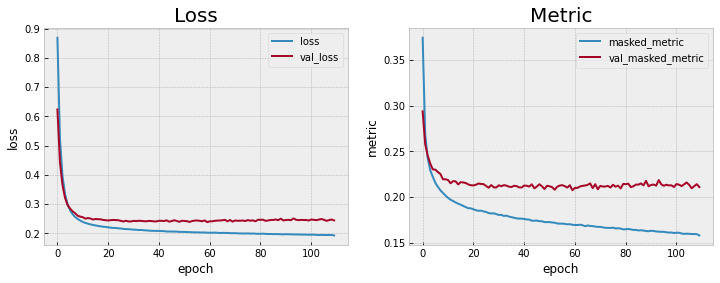

In [118]:
show_history(hist, 'loss', 'masked_cross_entropy')

In [119]:
pred = make_predictor(test_q, model, n_item, batch_size)
pred

array([[  37,  880,  608, ...,   34,  703,  612],
       [ 547,  134,  171, ...,  435,  414,   26],
       [1253, 1237,  611, ...,  985,  101,  486],
       ...,
       [  14,   44,    9, ...,  586,  195,   15],
       [  97,   64,  151, ...,  120,  128,  432],
       [ 726, 1531,  132, ...,   37,  206, 1466]])

In [120]:
m_ndcg = 0
m_recall = 0
m_precision = 0
map_k = 0
for i in range(len(pred)):
    rec = pred[i]
    gt = test_a.at[i, 'movieId']
    m_ndcg += ndcg(gt, rec)
    m_recall += recall(gt, rec)
    m_precision += precision(gt, rec)
    map_k += AP_k(gt, rec)
m_ndcg /= len(pred)
m_recall /= len(pred)
m_precision /= len(pred)
map_k /= len(pred)

In [121]:
m_ndcg

0.19953306565202317

In [122]:
m_recall

0.2364242215706336

In [123]:
m_precision

0.17508278145695344

In [124]:
map_k

0.14121136391460998